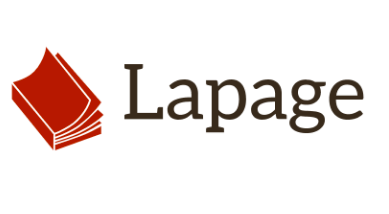

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pylab as pl
import numpy as np
import plotly.express as px
import statistics
from datetime import datetime, date
from pandas_profiling import ProfileReport
from scipy import stats
from scipy.stats import pareto
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from abc_analysis import abc_analysis, abc_plot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Scénario
Vous êtes consultant Data Analyst chez Lapage, une grande librairie généraliste en ligne très réputée. Vous êtes directement rattaché au service Marketing.
Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. Vous intervenez car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

# Mission

Une analyse des différents indicateurs de vente, qui a été demandée directement par Antoine. Je t’ai mis en pièce jointe l’e-mail qu’il m’a envoyé résumant ses demandes.
<br>
* Identifier les différents indicateurs et graphiques autour du chiffre d'affaires. 
* Analyser l’évolution dans le temps et mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale ?
* Faire un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.
Enfin, j’aimerais avoir quelques informations sur les profils de nos clients, et également la
répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.
Une analyse plus ciblée sur les clients : l’objectif serait cette fois-ci de comprendre le comportement de nos clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques. Pour cela, je t’invite à voir avec Julie, qui te précisera directement ses demandes à ce niveau.


Regarder en particulier :
* Le lien entre le genre d’un client et les catégories des livres achetés
* Le lien entre l’âge des clients et le montant total des achats
* La fréquence d’achat
* La taille du panier moyen et les catégories des livres achetés

**Détail du nettoyage des données : vous présenterez ici l’ensemble des choix et actions que vous avez réalisés afin d’obtenir un jeu de données exploitable.
Restitution de l’analyse : les chiffres clés, KPI, graphiques générés, corrélations calculées, etc.**

* Réaliser une analyse bivariée pour interpréter des données
* Réaliser un test statistique
* Analyser des séries temporelles

# Données
* Compréhension des données
* Utilisation de Panda Profiling
* Rapprochement des tables

## Compréhension des données
Chargement des 3 fichiers csv avec la fonction read_csv de Pandas
<br>Utilisation des fonctions **head(), info(), describe()**

In [2]:
df_customers= pd.read_csv("customers.csv")
df_products= pd.read_csv("products.csv")
df_transactions= pd.read_csv("transactions.csv")

In [3]:
df_customers.head()

client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943

In [4]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [5]:
df_customers.describe()

birth
count  8623.000000
mean   1978.280877
std      16.919535
min    1929.000000
25%    1966.000000
50%    1979.000000
75%    1992.000000
max    2004.000000

In [6]:
df_products.head()

id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0

In [7]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [8]:
df_products.describe()

price        categ
count  3287.000000  3287.000000
mean     21.856641     0.370246
std      29.847908     0.615387
min      -1.000000     0.000000
25%       6.990000     0.000000
50%      13.060000     0.000000
75%      22.990000     1.000000
max     300.000000     2.000000

In [9]:
df_transactions.head()

id_prod                        date session_id client_id
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232

In [10]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [11]:
df_transactions.describe()

id_prod                             date session_id client_id
count   679532                           679532     679532    679532
unique    3267                           679371     342316      8602
top      1_369  test_2021-03-01 02:30:02.237413        s_0    c_1609
freq      2252                               13        200     25488

## Utilisation de Panda Profiling

In [12]:
profileweb = ProfileReport(df_customers, title="Rapport de la base de donnée customers")
profileweb

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
profileweb = ProfileReport(df_products, title="Rapport de la base de donnée products")
profileweb

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
profileweb = ProfileReport(df_transactions, title="Rapport de la base de donnée transactions")
profileweb

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Rapprochement des tables

In [15]:
df_transactions_customers=pd.merge(df_transactions,df_customers, on='client_id')
df_transactions_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679532 entries, 0 to 679531
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
 4   sex         679532 non-null  object
 5   birth       679532 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 36.3+ MB


In [16]:
df_transactions_customers_products=pd.merge(df_transactions_customers,df_products, on='id_prod')
df_transactions_customers_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679311 entries, 0 to 679310
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679311 non-null  object 
 1   date        679311 non-null  object 
 2   session_id  679311 non-null  object 
 3   client_id   679311 non-null  object 
 4   sex         679311 non-null  object 
 5   birth       679311 non-null  int64  
 6   price       679311 non-null  float64
 7   categ       679311 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 46.6+ MB


In [17]:
profileweb = ProfileReport(df_transactions_customers_products, title="Rapport de la base de donnée transactions,customers,products")
profileweb

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
df_transactions_customers_products.head()

id_prod                        date session_id client_id sex  birth  price  \
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103   f   1986   4.18   
1  0_1518  2021-07-20 13:21:29.043970    s_64849     c_103   f   1986   4.18   
2  0_1518  2022-08-20 13:21:29.043970   s_255965     c_103   f   1986   4.18   
3  0_1518  2021-05-09 11:52:55.100386    s_32104    c_6714   f   1968   4.18   
4  0_1518  2022-05-30 01:17:07.487046   s_216118    c_6714   f   1968   4.18   

   categ  
0      0  
1      0  
2      0  
3      0  
4      0

In [19]:
#duplicate
df_transactions_customers_products.loc[df_transactions_customers_products.duplicated(keep=False),:]

id_prod                             date session_id client_id sex  \
678494     T_0  test_2021-03-01 02:30:02.237419        s_0      ct_0   f   
678496     T_0  test_2021-03-01 02:30:02.237436        s_0      ct_0   f   
678497     T_0  test_2021-03-01 02:30:02.237430        s_0      ct_0   f   
678498     T_0  test_2021-03-01 02:30:02.237449        s_0      ct_0   f   
678499     T_0  test_2021-03-01 02:30:02.237444        s_0      ct_0   f   
...        ...                              ...        ...       ...  ..   
678688     T_0  test_2021-03-01 02:30:02.237421        s_0      ct_1   m   
678689     T_0  test_2021-03-01 02:30:02.237420        s_0      ct_1   m   
678690     T_0  test_2021-03-01 02:30:02.237427        s_0      ct_1   m   
678692     T_0  test_2021-03-01 02:30:02.237424        s_0      ct_1   m   
678693     T_0  test_2021-03-01 02:30:02.237425        s_0      ct_1   m   

        birth  price  categ  
678494   2001   -1.0      0  
678496   2001   -1.0      0  
678497   2001   -1.0      0  
678498   2001   -1.0      0  
678499   2001   -1.0      0  
...       ...    ...    ...  
678688   2001   -1.0      0  
678689   2001   -1.0      0  
678690   2001   -1.0      0  
678692   2001   -1.0      0  
678693   2001   -1.0      0  

[183 rows x 8 columns]

In [20]:
#Nettoyage des 183 rows dupliquées
df_transactions_customers_products_duplicates=df_transactions_customers_products.drop_duplicates()

#Definir dataframe prix == -1.0 (74rows)
df_prix_inferieure_0=df_transactions_customers_products_duplicates[df_transactions_customers_products_duplicates['price']< 0]

#Definir dataframe prod test (74rows)
df_prod_test=df_transactions_customers_products_duplicates[df_transactions_customers_products_duplicates['id_prod']== 'T_0']

In [21]:
#verifier la similutide des deux dataframes id prod = test et prix =-1
df_prix_inferieure_0.equals(df_prod_test)

True

In [22]:
#Filtre et remplace les valeurs test par Nan
df_transactions_customers_products_duplicates.loc[df_transactions_customers_products_duplicates['price']==-1.0,'price'] = np.nan

#Supression des valeur Test prod
df=df_transactions_customers_products_duplicates.dropna(axis=0)

## Time Series

In [23]:
#fonction split
df["Date"]=df["date"].apply(lambda x: x.split()[0])

#To datetime a lieu d'object
df.Date = pd.to_datetime(df.Date)

#info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679310
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  object        
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   sex         679111 non-null  object        
 5   birth       679111 non-null  int64         
 6   price       679111 non-null  float64       
 7   categ       679111 non-null  int64         
 8   Date        679111 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 51.8+ MB


In [24]:
#Set_index
df=df.set_index('Date')

#création d'une nouvelle feature avec l'année
df['ANNEE']= df.index.year

#création d'une nouvelle feature avec le nom du mois
df['MOIS'] =df.index.month_name()

#création d'une nouvelle feature avec le nom du jour
df['JOUR']=df.index.day_name()

In [25]:
#Birth date
today = date.today()
df['age']=df.apply(lambda x : today.year-x['birth'],axis=1)

In [26]:
df.head()

id_prod                        date session_id client_id sex  \
Date                                                                      
2022-05-20  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103   f   
2021-07-20  0_1518  2021-07-20 13:21:29.043970    s_64849     c_103   f   
2022-08-20  0_1518  2022-08-20 13:21:29.043970   s_255965     c_103   f   
2021-05-09  0_1518  2021-05-09 11:52:55.100386    s_32104    c_6714   f   
2022-05-30  0_1518  2022-05-30 01:17:07.487046   s_216118    c_6714   f   

            birth  price  categ  ANNEE    MOIS      JOUR  age  
Date                                                           
2022-05-20   1986   4.18      0   2022     May    Friday   36  
2021-07-20   1986   4.18      0   2021    July   Tuesday   36  
2022-08-20   1986   4.18      0   2022  August  Saturday   36  
2021-05-09   1968   4.18      0   2021     May    Sunday   54  
2022-05-30   1968   4.18      0   2022     May    Monday   54

# Identifier les différents indicateurs et graphiques autour du chiffre d'affaires. 

In [27]:
#Calcul du CA total
CA_total = df["price"].sum()

#Affichage CA  total avec la fonction print()
print(f'Le chiffre d’affaires total réalisé est de : {round(CA_total ,2)} euros')

Le chiffre d’affaires total réalisé est de : 11853728.68 euros


In [28]:
#Affichage CA par catégorie avec la fonction groupby()
CA_categ=df.groupby('categ')['price'].sum()

#Affichage CA par categorie avec la fonction print()
print(f'Le chiffre d’affaires réalisé par la catégorie 0 est de : {round(CA_categ[0],2)} euros')
print(f'Le chiffre d’affaires réalisé par la catégorie 1 est de : {round(CA_categ[1],2)} euros')
print(f'Le chiffre d’affaires réalisé par la catégorie 2 est de : {round(CA_categ[2],2)} euros')

Le chiffre d’affaires réalisé par la catégorie 0 est de : 4419730.97 euros
Le chiffre d’affaires réalisé par la catégorie 1 est de : 4653722.69 euros
Le chiffre d’affaires réalisé par la catégorie 2 est de : 2780275.02 euros


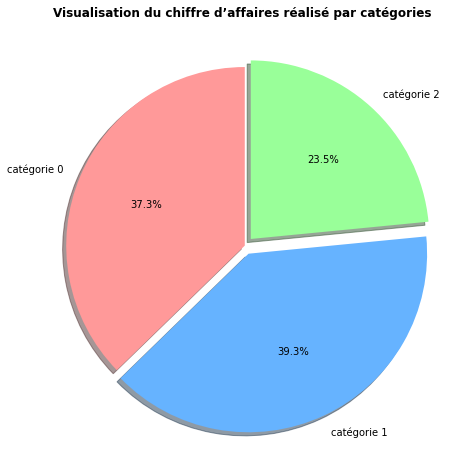

In [29]:
fig = plt.figure(figsize= [8,12])
labels = 'catégorie 0','catégorie 1','catégorie 2'

sizes=[CA_categ[0], 
       CA_categ[1],
       CA_categ[2]] 

explode = (0,0.05,0.05)  
ax = fig.add_subplot()

#add colors
colors = ['#ff9999','#66b3ff','#99ff99']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax.set_title('Visualisation du chiffre d’affaires réalisé par catégories ',fontweight="bold")
plt.show()

In [30]:
#Calcul du nombre de ventes
Nb_vente_total = df["price"].count()

#Affichage nombre de ventes total avec la fonction print()
print(f'Le nombre total de ventes réalisé est de : {round(Nb_vente_total ,2)} articles')

Le nombre total de ventes réalisé est de : 679111 articles


In [31]:
#Affichage nombre de ventes par catégorie avec la fonction groupby()
Nb_vente_categ=df.groupby('categ')['price'].count()

#Affichage nb ventes par categorie avec la fonction print()
print(f'Le nombre total de ventes réalisés par la catégorie 0 est de : {round(Nb_vente_categ[0],2)} euros')
print(f'Le nombre total de ventes réalisés par la catégorie 1 est de : {round(Nb_vente_categ[1],2)} euros')
print(f'Le nombre total de ventes réalisés par la catégorie 2 est de : {round(Nb_vente_categ[2],2)} euros')

Le nombre total de ventes réalisés par la catégorie 0 est de : 415459 euros
Le nombre total de ventes réalisés par la catégorie 1 est de : 227169 euros
Le nombre total de ventes réalisés par la catégorie 2 est de : 36483 euros


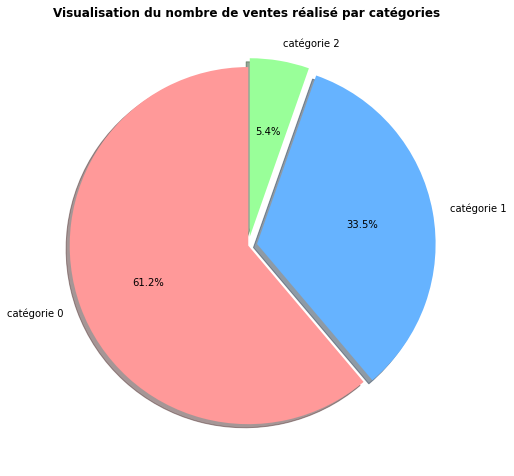

In [32]:
fig = plt.figure(figsize= [8,12])
labels = 'catégorie 0','catégorie 1','catégorie 2'

sizes=[Nb_vente_categ[0], 
       Nb_vente_categ[1],
       Nb_vente_categ[2]] 

explode = (0,0.05,0.05)  
ax = fig.add_subplot()

#add colors
colors = ['#ff9999','#66b3ff','#99ff99']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax.set_title('Visualisation du nombre de ventes réalisé par catégories ',fontweight="bold")
plt.show()

## Analyser l’évolution dans le temps et mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale

<AxesSubplot:xlabel='ANNEE', ylabel='count'>

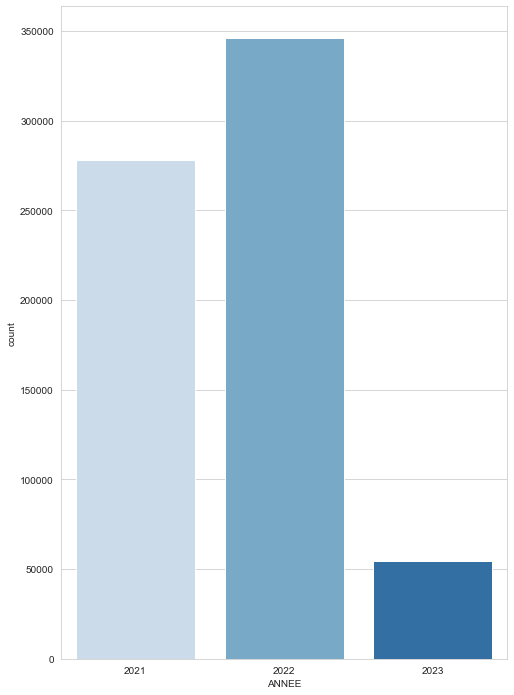

In [33]:
fig = plt.figure(figsize= [8,12])
sns.set_style('whitegrid')
sns.countplot(x='ANNEE', data=df, palette='Blues')

In [34]:
TDA =pd.pivot_table(df, index=['Date'],values=['price','ANNEE'], aggfunc={'price': np.sum})

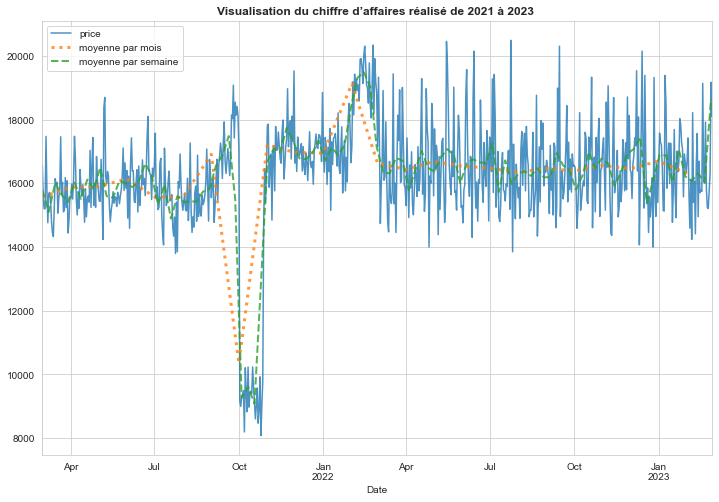

In [35]:
plt.figure(figsize=(12,8))
TDA.loc['2021':'2023']['price'].plot(alpha=0.8)
TDA.loc['2021':'2023']['price'].resample('M').mean().plot(label='moyenne par mois',lw=3, ls=':', alpha=0.8)
TDA.loc['2021':'2023']['price'].resample('W').mean().plot(label='moyenne par semaine',lw=2, ls='--', alpha=0.8)
plt.title('Visualisation du chiffre d’affaires réalisé de 2021 à 2023 ',fontweight="bold")
plt.legend()
plt.show()

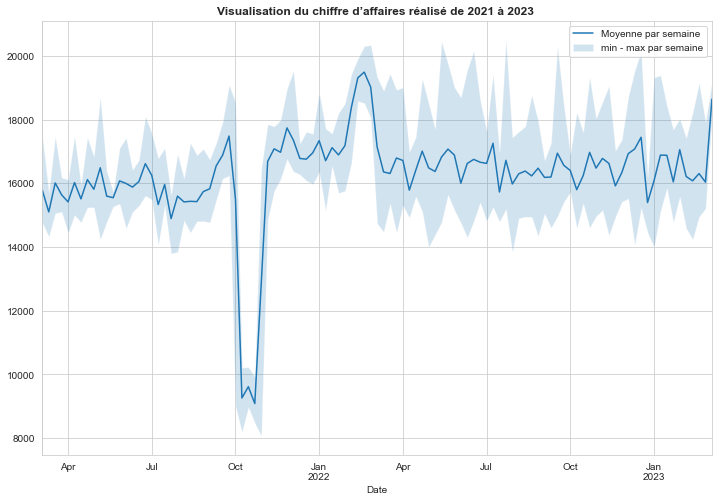

In [36]:
m=TDA['2021':'2023']['price'].resample('W').agg(['mean','min','max'])

plt.figure(figsize=(12,8))
m['mean']['2021':'2023'].plot(label='Moyenne par semaine')
plt.fill_between(m.index,m['max'],m['min'],alpha=0.2, label='min - max par semaine')
plt.title('Visualisation du chiffre d’affaires réalisé de 2021 à 2023 ',fontweight="bold")
plt.legend()
plt.show()


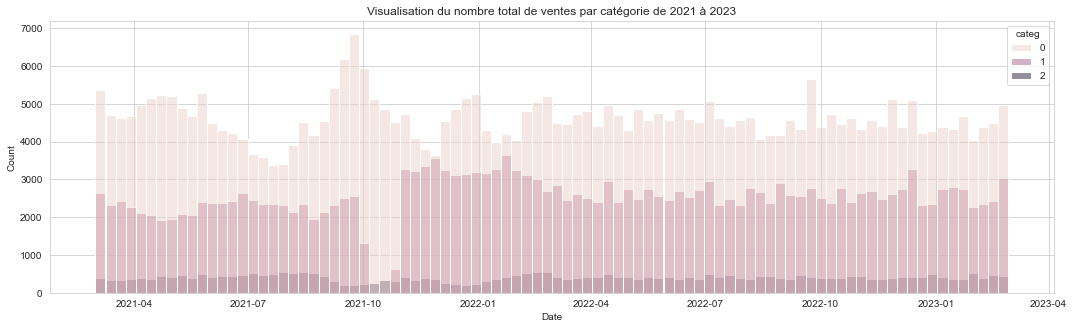

In [37]:
fig, ax = plt.subplots(figsize=(18,5))
sns.set_style('whitegrid')
sns.histplot(data=df, x='Date',hue='categ')
plt.title('Visualisation du nombre total de ventes par catégorie de 2021 à 2023')
plt.show()

In [38]:
df['price'].mean()
df['price'].median()
df['price'].mode()

0    15.99
dtype: float64

--------------------
0
moy:
 10.638188052305958
med:
 9.99
mod:
 0    4.99
dtype: float64


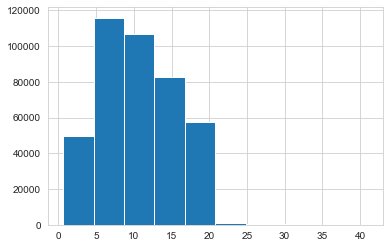

--------------------
1
moy:
 20.485729523011056
med:
 19.08
mod:
 0    15.99
dtype: float64


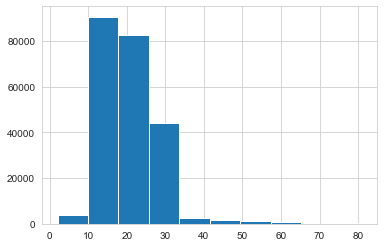

--------------------
2
moy:
 76.20741221941515
med:
 62.83
mod:
 0    68.99
dtype: float64


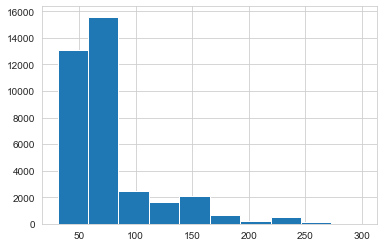

In [39]:
for cat in df["categ"].unique():
    subset = df[df.categ == cat] # Création du sous-échantillon
    print("-"*20)
    print(cat)
    print("moy:\n",subset['price'].mean())
    print("med:\n",subset['price'].median())
    print("mod:\n",subset['price'].mode())
    subset["price"].hist() # Crée l'histogramme
    plt.show() # Affiche l'histogramme

## 3 Methodes d'imputation pour les valeurs d'octobre 2021

### SimpleImputer

In [40]:
TDJ =pd.pivot_table(df, index=['Date'],columns=['categ'],values=['price'], aggfunc={'price': np.sum})

In [41]:
from sklearn.impute import SimpleImputer

In [42]:
imp_mean = SimpleImputer(strategy='mean')

In [43]:
df_imput=imp_mean.fit_transform(TDJ)

In [44]:
df_imputed = pd.DataFrame(df_imput)

In [45]:
TDJ=TDJ.reset_index()

In [46]:
df_inner = TDJ.merge(df_imputed, how='left', left_index=True, right_index=True)

In [47]:
#df_inner =df_inner.drop([('price', 0), ('price', 1),('price', 2)],axis=1)

In [48]:
df_inner=df_inner.rename(columns ={('Date', ''): 'Date'})

In [68]:
df_inner.loc['2021-10':'2021-10']

(price, 0)  (price, 1)  (price, 2)        0            1        2
Date                                                                         
2021-10-01     6950.50     7003.79     3104.05  6950.50  7003.790000  3104.05
2021-10-02     7141.01         NaN     2041.12  7141.01  6610.401548  2041.12
2021-10-03     6786.57         NaN     2206.48  6786.57  6610.401548  2206.48
2021-10-04     6533.60         NaN     2746.08  6533.60  6610.401548  2746.08
2021-10-05     6357.91         NaN     3032.55  6357.91  6610.401548  3032.55
2021-10-06     7546.58         NaN     1944.11  7546.58  6610.401548  1944.11
2021-10-07     6404.01         NaN     1787.07  6404.01  6610.401548  1787.07
2021-10-08     7069.53         NaN     3137.82  7069.53  6610.401548  3137.82
2021-10-09     6808.69         NaN     2616.67  6808.69  6610.401548  2616.67
2021-10-10     6490.98         NaN     2334.67  6490.98  6610.401548  2334.67
2021-10-11     7005.40         NaN     3225.16  7005.40  6610.401548  3225.16
2021-10-12     6706.97         NaN     2264.18  6706.97  6610.401548  2264.18
2021-10-13     6760.40         NaN     2666.82  6760.40  6610.401548  2666.82
2021-10-14     6422.39         NaN     3047.39  6422.39  6610.401548  3047.39
2021-10-15     6697.08         NaN     2701.75  6697.08  6610.401548  2701.75
2021-10-16     6898.14         NaN     3330.88  6898.14  6610.401548  3330.88
2021-10-17     6492.60         NaN     3065.38  6492.60  6610.401548  3065.38
2021-10-18     6376.43         NaN     2707.29  6376.43  6610.401548  2707.29
2021-10-19     5785.71         NaN     2816.00  5785.71  6610.401548  2816.00
2021-10-20     5902.77         NaN     3118.42  5902.77  6610.401548  3118.42
2021-10-21     6438.85         NaN     3132.94  6438.85  6610.401548  3132.94
2021-10-22     6051.86         NaN     2416.00  6051.86  6610.401548  2416.00
2021-10-23     5704.26         NaN     3206.38  5704.26  6610.401548  3206.38
2021-10-24     6036.65         NaN     3886.54  6036.65  6610.401548  3886.54
2021-10-25     5817.82         NaN     2258.22  5817.82  6610.401548  2258.22
2021-10-26     6335.01         NaN     2685.78  6335.01  6610.401548  2685.78
2021-10-27     5822.24         NaN     3967.29  5822.24  6610.401548  3967.29
2021-10-28     5837.61     6317.99     2602.82  5837.61  6317.990000  2602.82
2021-10-29     6410.57     6425.18     3617.88  6410.57  6425.180000  3617.88
2021-10-30     5734.62     6753.69     2898.47  5734.62  6753.690000  2898.47
2021-10-31     5924.07     7261.67     3219.38  5924.07  7261.670000  3219.38

In [50]:
df_inner=df_inner.set_index('Date')

In [51]:
TDJ=TDJ.set_index('Date', '')

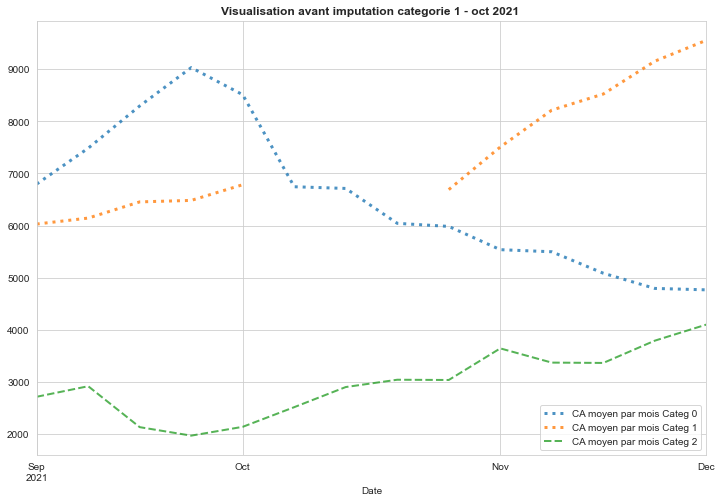

In [52]:
plt.figure(figsize=(12,8))
TDJ.loc['2021-09':'2021-11'][('price',  0)].resample('W').mean().plot(label='CA moyen par mois Categ 0',lw=3, ls=':', alpha=0.8)
TDJ.loc['2021-09':'2021-11'][('price',  1)].resample('W').mean().plot(label='CA moyen par mois Categ 1',lw=3, ls=':', alpha=0.8)
TDJ.loc['2021-09':'2021-11'][('price',  2)].resample('W').mean().plot(label='CA moyen par mois Categ 2',lw=2, ls='--', alpha=0.8)
plt.title('Visualisation avant imputation categorie 1 - oct 2021 ',fontweight="bold")
plt.legend()
plt.show()

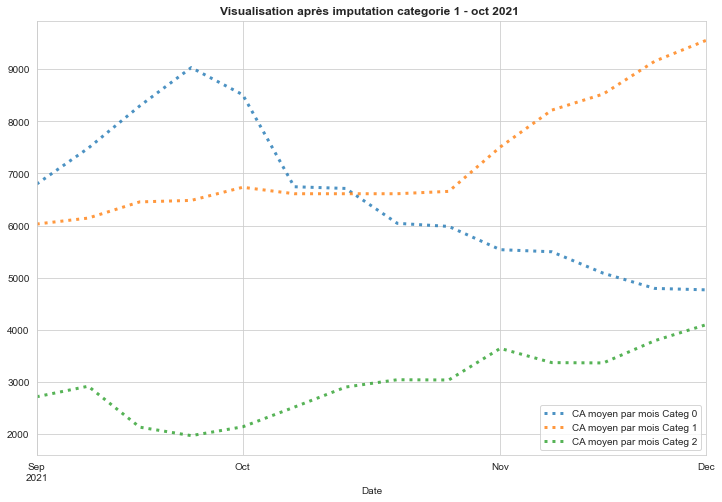

In [53]:
plt.figure(figsize=(12,8))
df_inner.loc['2021-09':'2021-11'][0].resample('W').mean().plot(label='CA moyen par mois Categ 0',lw=3, ls=':', alpha=0.8)
df_inner.loc['2021-09':'2021-11'][1].resample('W').mean().plot(label='CA moyen par mois Categ 1',lw=3, ls=':', alpha=0.8)
df_inner.loc['2021-09':'2021-11'][2].resample('W').mean().plot(label='CA moyen par mois Categ 2',lw=3, ls=':', alpha=0.8)
plt.title('Visualisation après imputation categorie 1 - oct 2021 ',fontweight="bold")
plt.legend()
plt.show()

In [56]:
X = TDJ[[('price',  0),('price',  2)]]

In [57]:
y = TDJ.drop([('price',  0),('price',  2)],axis=1)

### KNNImputer 

In [64]:
from sklearn.impute import KNNImputer

In [69]:
impute_knn = KNNImputer(n_neighbors=1)

In [70]:
impute_knn.fit_transform(y)

array([[ 6811.53     ],
       [ 5627.15     ],
       [ 5691.41     ],
       [ 6098.98     ],
       [ 7071.21     ],
       [ 5884.54     ],
       [ 5590.16     ],
       [ 6222.03     ],
       [ 5514.7      ],
       [ 6069.45     ],
       [ 5586.35     ],
       [ 5419.79     ],
       [ 5637.18     ],
       [ 6042.34     ],
       [ 5924.49     ],
       [ 6440.82     ],
       [ 6166.55     ],
       [ 5739.52     ],
       [ 6603.42     ],
       [ 6626.91     ],
       [ 6556.11     ],
       [ 5701.28     ],
       [ 5817.45     ],
       [ 6079.88     ],
       [ 6151.46     ],
       [ 6322.85     ],
       [ 6094.       ],
       [ 6404.93     ],
       [ 4942.75     ],
       [ 5914.05     ],
       [ 6220.88     ],
       [ 5127.73     ],
       [ 5883.8      ],
       [ 6060.86     ],
       [ 5354.04     ],
       [ 5569.57     ],
       [ 5841.35     ],
       [ 5122.4      ],
       [ 5279.02     ],
       [ 5151.71     ],
       [ 5500.84     ],
       [ 5337.34

### Iterative Imputer

In [72]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [73]:
impute_it = IterativeImputer()
impute_it.fit_transform(y)

array([[ 6811.53     ],
       [ 5627.15     ],
       [ 5691.41     ],
       [ 6098.98     ],
       [ 7071.21     ],
       [ 5884.54     ],
       [ 5590.16     ],
       [ 6222.03     ],
       [ 5514.7      ],
       [ 6069.45     ],
       [ 5586.35     ],
       [ 5419.79     ],
       [ 5637.18     ],
       [ 6042.34     ],
       [ 5924.49     ],
       [ 6440.82     ],
       [ 6166.55     ],
       [ 5739.52     ],
       [ 6603.42     ],
       [ 6626.91     ],
       [ 6556.11     ],
       [ 5701.28     ],
       [ 5817.45     ],
       [ 6079.88     ],
       [ 6151.46     ],
       [ 6322.85     ],
       [ 6094.       ],
       [ 6404.93     ],
       [ 4942.75     ],
       [ 5914.05     ],
       [ 6220.88     ],
       [ 5127.73     ],
       [ 5883.8      ],
       [ 6060.86     ],
       [ 5354.04     ],
       [ 5569.57     ],
       [ 5841.35     ],
       [ 5122.4      ],
       [ 5279.02     ],
       [ 5151.71     ],
       [ 5500.84     ],
       [ 5337.34

Nous avons testé 3 methodes d'imputation avec le module **impute** de Sklearn
* SimpleImputer
* KNNImputer
* IterativeImputer

## Faire un zoom sur les références, 
### les tops et les flops sur l'ensemble des produits

In [ ]:
#pivot table reference(id_prod)
TDE =pd.pivot_table(df, index=['id_prod'],values=['price'], aggfunc={'price': np.sum})

#top
TDE_top=TDE.sort_values(by='price',ascending=False)
TDE_top.head(10)

In [ ]:
#flop
TDE_flop=TDE.sort_values(by='price',ascending=True)
TDE_flop.head(10)

### les tops et les flops par categorie

In [ ]:
#pivot table reference(id_prod) par categorie
TDD =pd.pivot_table(df, index=['id_prod'],columns=['categ'],values=['price'], aggfunc={'price': np.sum})

#fillna
TDD = TDD.fillna(0)

In [ ]:
#affichage top 10 ordre croissant cat0
TDD_cat0_top=TDD.sort_values(by=('price', 0),ascending=False)
TDD_cat0_top.head(10)

In [ ]:
#affichage flop 10 categ 0
TDD_cat0_flop=TDD.sort_values(by=('price', 0),ascending=True)
TDD_cat0_flop.head(10)

In [ ]:
#affichage top 10 cat1
TDD_cat1_top=TDD.sort_values(by=('price', 1),ascending=False)
TDD_cat1_top.head(10)

In [ ]:
#affichage flop 10 categ 1
TDD_cat1_flop=TDD.sort_values(by=('price', 1),ascending=True)
TDD_cat1_flop.head(10)

In [ ]:
#affichage top 10 cat2
TDD_cat2_top=TDD.sort_values(by=('price', 2),ascending=False)
TDD_cat2_top.head(10)

In [ ]:
#affichage flop 10 categ 2
TDD_cat2_flop=TDD.sort_values(by=('price', 2),ascending=True)
TDD_cat2_flop.head(10)

## La répartition par catégorie

## Informations sur les profils de nos clients, 

In [ ]:
#pivot table reference(id_prod) par categorie
TDF =pd.pivot_table(df, index=['client_id'],columns=['categ'],values=['price'], aggfunc={'price': np.sum})

#fillna()
TDF=TDF.fillna(0)

#création feature CA
TDF['CA']= TDF[('price', 0)]+TDF[('price', 1)]+TDF[('price', 2)]

## La répartition du chiffre d'affaires

In [ ]:
## Concentration CA (Lorenz)
dep = TDF['CA']
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S,2)
gini

In [ ]:
#Graphique concentration dU CA
plt.figure(figsize= [8,8])
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz)
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
plt.text(0.2,0.8,"Gini ="+ str(gini))
plt.title("Courbe lorenz - CA total",fontweight="bold")
ax.set_xlabel("Produit")
ax.set_ylabel("CA")
plt.grid()
plt.show()

## La répartition du chiffre d'affaires par catégorie

In [ ]:
dep = TDF[('price', 0)]
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S,2)
gini

In [ ]:
plt.figure(figsize= [8,8])
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz)
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
plt.text(0.2,0.8,"Gini ="+ str(gini))
plt.title("Courbe lorenz - CA cat 0",fontweight="bold")
ax.set_xlabel("Produit")
ax.set_ylabel("CA cat 0")
plt.grid()
plt.show()

In [ ]:
dep = TDF[('price', 1)]
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S,2)
gini

In [ ]:
plt.figure(figsize= [8,8])
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz)
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
plt.text(0.2,0.8,"Gini ="+ str(gini))
plt.title("Courbe lorenz - CA cat 1",fontweight="bold")
ax.set_xlabel("Produit")
ax.set_ylabel("CA cat 1")
plt.grid()
plt.show()

In [ ]:
dep = TDF[('price', 2)]
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S,2)
gini

In [ ]:
plt.figure(figsize= [8,8])
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz)
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
plt.text(0.2,0.8,"Gini ="+ str(gini))
plt.title("Courbe lorenz - CA cat 2",fontweight="bold")
ax.set_xlabel("Produit")
ax.set_ylabel("CA cat 2")
plt.grid()
plt.show()

On peut observer que :

* La catégorie 1 à la répartition du CA la plus égalitaire 
* La catégorie 2 à la répartition du CA la plus inégalitaire

## Le lien entre le genre d’un client et les catégories des livres achetés

In [ ]:
TDC =pd.pivot_table(df, index=['categ'], columns=['sex'],values=['age','price'], aggfunc={'age' :np.mean, 'price': np.mean})

TDC

On peut observer que :
* La catégorie 0 à en moyenne le plus petit  panier moyen (10eur) avec une moyenne d'age femme/homme entre 44 et 43 ans
* La catégorie 1 à un panier moyen à 20eur avec une moyenne d'age la plus elevée femme/homme entre 48 et 46 ans
* La catégorie 2 à un panier moyen le plus elevé à 75eur avec une moyenne d'age  femme/homme entre 26 et 25 ans

In [ ]:
fig = plt.figure(figsize= [8,12])
sns.set_style('whitegrid')
sns.countplot(x='categ', hue='sex', data=df, palette='Blues')

## Le lien entre l’âge des clients et le montant total des achats

In [ ]:
fig = plt.figure(figsize= [20,8])
sns.set_style('whitegrid')
sns.countplot(x='age', data=df, palette='dark:salmon_r')

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(x='categ', y= 'age', data=df, palette="Spectral" )

## La fréquence d’achat

In [ ]:
#Pivot table
TBG = df.pivot_table(index = ['session_id'],columns=['Date'],values=['price'], aggfunc={'price': np.mean})

#fillna()
TBG =TBG.fillna(0)

In [ ]:
BG_transposed = TBG.T

In [ ]:
TBG_transposed=TBG_transposed.reset_index()

In [ ]:
TBG_transposed.drop(['level_0'], axis=1,inplace=True)

In [ ]:
freq=TBG['session_id'].value_counts(normalize=True)*100

In [ ]:
freq

In [ ]:
TBG

## La fréquence d’achat / categ

In [ ]:
plt.figure(figsize=(12,8))
TBG .loc['2021':'2023']['session_id'].plot(alpha=0.8)
TBG .loc['2021':'2023']['session_id'].resample('M').mean().plot(label='moyenne par mois',lw=3, ls=':', alpha=0.8)
TBG .loc['2021':'2023']['session_id'].resample('W').mean().plot(label='moyenne par semaine',lw=2, ls='--', alpha=0.8)
plt.title('Visualisation du chiffre d’affaires réalisé de 2021 à 2023 ',fontweight="bold")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
TBG .loc['2021':'2023']['price'].plot(alpha=0.8)
TBG .loc['2021':'2023']['price'].resample('M').mean().plot(label='moyenne par mois',lw=3, ls=':', alpha=0.8)
TBG .loc['2021':'2023']['price'].resample('W').mean().plot(label='moyenne par semaine',lw=2, ls='--', alpha=0.8)
plt.title('Visualisation du chiffre d’affaires réalisé de 2021 à 2023 ',fontweight="bold")
plt.legend()
plt.show()

## La taille du panier moyen et les catégories des livres achetés

In [ ]:
TBG

# Imputation

In [ ]:
plt.figure(figsize=(12,8))
TDA.loc['2021-09':'2021-11']['price'].plot(alpha=0.8)
TDA.loc['2021-09':'2021-11']['price'].resample('M').mean().plot(label='moyenne par mois',lw=3, ls=':', alpha=0.8)
TDA.loc['2021-09':'2021-11']['price'].resample('W').mean().plot(label='moyenne par semaine',lw=2, ls='--', alpha=0.8)
plt.title('Visualisation du chiffre d’affaires réalisé de septembre à novembre 2021',fontweight="bold")
plt.legend()
plt.show()

In [ ]:
m=TDA['2021-09':'2021-11']['price'].resample('W').agg(['mean','min','max'])

plt.figure(figsize=(12,8))
m['mean']['2021-09':'2021-11'].plot(label='Moyenne par semaine')
plt.fill_between(m.index,m['max'],m['min'],alpha=0.2, label='min - max par semaine')
plt.title('Visualisation du chiffre d’affaires réalisé de 2021 à 2023 ',fontweight="bold")
plt.legend()
plt.show()


# Building a Regression model